# Unfolded SDK Machine Learning Demo

The purpose of the model is to predict the median_house_value in California and then clustering it by the predicted prices.

## Dependencies 

In [1]:
!pip install pandas==1.3.2 numpy==1.19.5 sklearn==0.0 geopy==2.2.0 scipy==1.7.1 seaborn==0.11.2 matplotlib==3.4.3 tensorflow==2.6.0 unfolded.map-sdk==0.3.0

/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


## Imports

In [2]:
from uuid import uuid4
import requests

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from geopy.distance import geodesic
from scipy.cluster.vq import vq
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow import keras
from tensorflow.keras import Sequential, optimizers
from tensorflow.keras.layers import Dense, Flatten, Softmax

from unfolded.map_sdk import UnfoldedMap

2021-09-16 10:22:01.401975: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-16 10:22:01.402005: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Check package versions: 

In [3]:
print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")
print(f"seaborn version: {sns.__version__}")
print(f"tensorflow: {tf.__version__}")

pandas version: 1.3.2
numpy version: 1.19.5
seaborn version: 0.11.2
tensorflow: 2.6.0


## Data Loading

In [4]:
dataset_url = "https://actionengine-public.s3.us-east-2.amazonaws.com/housing.csv"
dataset_path = "housing.csv"

dataset_data = requests.get(dataset_url, allow_redirects=True)
with open(dataset_path, "wb") as dataset_file:
    dataset_file.write(dataset_data.content)

housing = pd.read_csv(dataset_path)
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Feature Engineering

### Population Clustering

In [5]:
population_in_CA = UnfoldedMap()
dataset_id = uuid4()

population_in_CA.add_dataset(
    {"uuid": dataset_id, "label": "Population_in_CA", "data": housing},
    auto_create_layers=False,
)

population_in_CA.add_layer(
    {
        "id": "population_CA",
        "type": "cluster",
        "config": {
            "label": "population in CA",
            "data_id": dataset_id,
            "columns": {"lat": "latitude", "lng": "longitude"},
            "is_visible": True,
            "color_scale": "quantize",
            "color_field": {"name": "population", "type": "real"},
        },
    }
)

population_in_CA.set_view_state(
    {"longitude": -119.417931, "latitude": 36.778259, "zoom": 5}
)

population_in_CA

UnfoldedMap()

This map shows clustering by city with the largest population 

Create a dictionary with latitude and longitude of the first 5 largest cities in CA

In [6]:
big_cities = {
    "Los Angeles": (34.052, -118.244),
    "San Diego": (32.716, -117.165),
    "San Jose": (37.339, -121.895),
    "San Francisco": (37.775, -122.419),
    "Fresno": (36.748, -119.772),
}

### Distance To Largest Cities

Create function to calculate nearest city

In [7]:
def closest_point(location, location_dict):
    shortest_distance = None
    shortest_distance_coordinates = None

    for loc in location_dict.values():
        distance = geodesic(location, loc).kilometers
        if shortest_distance is None or distance < shortest_distance:
            shortest_distance = distance
            shortest_distance_coordinates = loc
    return shortest_distance, shortest_distance_coordinates

Find and calculate the distance between each city in dataframe and nearest big city to it

In [8]:
housing["big_city"] = housing.apply(
    lambda x: closest_point((x["latitude"], x["longitude"]), big_cities), axis=1
)
housing["closest_location"] = [x[0] for x in housing["big_city"].values]
housing["big_city_dist"] = [x[1] for x in housing["big_city"].values]

housing = housing.drop("big_city", axis=1)

Make a dataframe from the data obtained above, with the coordinates of the nearest big city

In [9]:
lat = []
lon = []
target_lat = []
target_lon = []

for row in housing.itertuples():
    lon.append(row.longitude)
    lat.append(row.latitude)
    target_city = row.big_city_dist
    target_lat.append(target_city[0])
    target_lon.append(target_city[1])

coords_df = pd.DataFrame(
    {"lat": lat, "lon": lon, "target_lat": target_lat, "target_lon": target_lon}
)

In [10]:
distance_to_big_cities = UnfoldedMap()
dist_data_id = uuid4()

distance_to_big_cities.add_dataset(
    {
        "uuid": dist_data_id,
        "label": "Distance to closest big cities",
        "data": coords_df,
    },
    auto_create_layers=False,
)

distance_to_big_cities.add_layer(
    {
        "id": "closest_distance",
        "type": "arc",
        "config": {
            "data_id": dist_data_id,
            "label": "distance to closest big cities",
            "columns": {
                "lng0": "lon",
                "lng1": "target_lon",
                "lat0": "lat",
                "lat1": "target_lat",
            },
            "visConfig": {"opacity": 0.8, "thickness": 0.3},
            "is_visible": True,
        },
    }
)

distance_to_big_cities.set_view_state(
    {"longitude": -119.417931, "latitude": 36.778259, "zoom": 4.5}
)

distance_to_big_cities

UnfoldedMap()

This map shows a distance from each city to the nearest big city

## Data Preprocessing

In [11]:
# we can drop null values as their count is less than 5 %
housing.dropna(inplace=True)

X = pd.DataFrame(
    columns=[
        "longitude",
        "latitude",
        "housing_median_age",
        "total_rooms",
        "total_bedrooms",
        "population",
        "households",
        "median_income",
        "ocean_proximity",
    ],
    data=housing,
)
y = pd.DataFrame(columns=["median_house_value"], data=housing)

# creating dummy values for ocean_proximity
X = pd.get_dummies(
    data=X, columns=["ocean_proximity"], prefix=["ocean_proximity"], drop_first=True
)

## Data Splitting

Feature Scaling and split to test, train and validation

In [12]:
# dividing training data into test, validation and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=1
)

start_values = X_test.copy(deep=True)

Using standart scaling with mean and standard deviation from training dataset to avoid data leak

In [13]:
# feature standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

## Price Prediction Model

In [14]:
model = Sequential()

# input Layer
model.add(Dense(X.shape[1], activation="relu", input_dim=X.shape[1]))

# hidden Layer
model.add(Dense(512, activation="relu"))
model.add(Dense(512, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))

# output Layer
model.add(Dense(1, activation="linear"))

2021-09-16 10:22:30.487998: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-09-16 10:22:30.488036: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-16 10:22:30.488065: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kseniaevin-G3-3500): /proc/driver/nvidia/version does not exist
2021-09-16 10:22:30.488346: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
model.compile(loss="mse", optimizer="adam", metrics=["mse", "mae"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                156       
_________________________________________________________________
dense_1 (Dense)              (None, 512)               6656      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2

### Training

In [16]:
history = model.fit(
    X_train,
    y_train.to_numpy(),
    batch_size=10,
    epochs=70,
    verbose=1,
    validation_data=(X_val, y_val),
)

2021-09-16 10:22:30.630464: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/70
1226/1226 [==============================] - 4s 3ms/step - loss: 8364029440.0000 - mse: 8364029440.0000 - mae: 62775.0195 - val_loss: 5121113600.0000 - val_mse: 5121113600.0000 - val_mae: 53995.3359
Epoch 2/70
1226/1226 [==============================] - 3s 3ms/step - loss: 4301112832.0000 - mse: 4301112832.0000 - mae: 46895.2109 - val_loss: 4391387648.0000 - val_mse: 4391387648.0000 - val_mae: 46966.8672
Epoch 3/70
1226/1226 [==============================] - 5s 4ms/step - loss: 4103281664.0000 - mse: 4103281664.0000 - mae: 45341.2578 - val_loss: 4230914816.0000 - val_mse: 4230914816.0000 - val_mae: 44658.6719
Epoch 4/70
1226/1226 [==============================] - 5s 4ms/step - loss: 3987891456.0000 - mse: 3987891456.0000 - mae: 44562.0742 - val_loss: 4351267328.0000 - val_mse: 4351267840.0000 - val_mae: 44839.9844
Epoch 5/70
1226/1226 [==============================] - 4s 3ms/step - loss: 3809381120.0000 - mse: 3809381120.0000 - mae: 43413.4688 - val_loss: 4413275648.0000

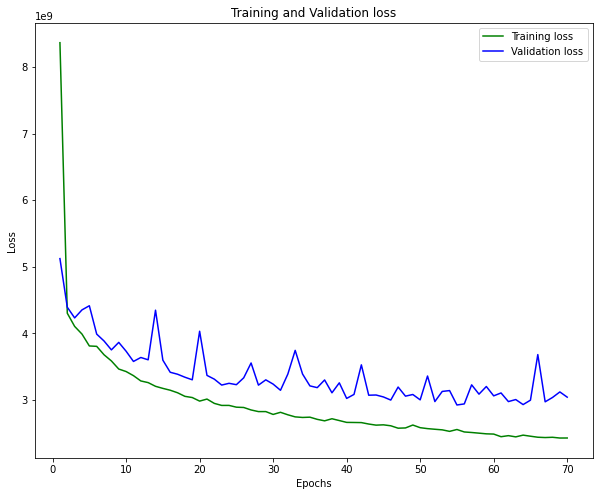

In [17]:
# summarize history for loss
loss_train = history.history["loss"]
loss_val = history.history["val_loss"]
epochs = range(1, 71)
plt.figure(figsize=(10, 8))
plt.plot(epochs, loss_train, "g", label="Training loss")
plt.plot(epochs, loss_val, "b", label="Validation loss")
plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Evaluation

In [18]:
y_pred = model.predict(X_test)
model.evaluate(X_test, y_test)

128/128 [==============================] - 0s 681us/step - loss: 2807665920.0000 - mse: 2807665920.0000 - mae: 35259.3047


[2807665920.0, 2807665920.0, 35259.3046875]

### Prediction

Create a dataframe with predicted values obtained from the model

In [19]:
predict_data = pd.DataFrame(
    columns=["longitude", "latitude"], data=start_values[["longitude", "latitude"]]
)
predict_data["price"] = y_pred

### Visualization

In [20]:
housing_predict_prices = UnfoldedMap()
price_data_id = uuid4()

housing_predict_prices.add_dataset(
    {
        "uuid": price_data_id,
        "label": "Predict housing prices in CA",
        "data": predict_data,
    },
    auto_create_layers=False,
)

housing_predict_prices.add_layer(
    {
        "id": "housing_prices",
        "type": "hexagon",
        "config": {
            "label": "housing prices",
            "data_id": price_data_id,
            "columns": {"lat": "latitude", "lng": "longitude"},
            "is_visible": True,
            "color_scale": "quantize",
            "color_field": {"name": "price", "type": "real"},
            "vis_config": {
                "colorRange": {
                    "colors": [
                        "#E6F598",
                        "#ABDDA4",
                        "#66C2A5",
                        "#3288BD",
                        "#5E4FA2",
                        "#9E0142",
                        "#D53E4F",
                        "#F46D43",
                        "#FDAE61",
                        "#FEE08B",
                    ]
                }
            },
        },
    }
)

housing_predict_prices.set_view_state(
    {"longitude": -119.417931, "latitude": 36.6, "zoom": 6}
)

housing_predict_prices

UnfoldedMap()

This map shows obtained prices on houses in CA

## Clustering Model

Create clusters with different price levels using the KMeans algorithm

In [21]:
k = 5
km = KMeans(n_clusters=k, init="k-means++")
X = predict_data[["latitude", "longitude", "price"]]

# clustering
dtf_X = X.copy()
dtf_X["cluster"] = km.fit_predict(X)

# add clustering info to the original dataset
predict_data[["cluster"]] = dtf_X[["cluster"]]

### Visualization

Text(0.5, 1.0, 'Clustering (k=5)')

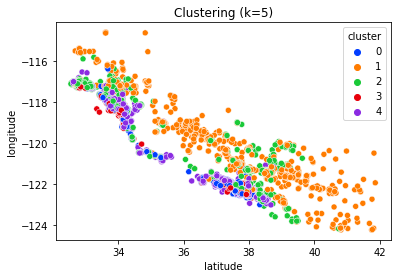

In [22]:
fig, ax = plt.subplots()
sns.scatterplot(
    x="latitude",
    y="longitude",
    data=predict_data,
    palette=sns.color_palette("bright", k),
    hue="cluster",
    size_order=[1, 0],
    ax=ax,
).set_title("Clustering (k=" + str(k) + ")")

In [23]:
prices_dataset_id = uuid4()
unfolded_map_prices = UnfoldedMap()

unfolded_map_prices.add_dataset(
    {"uuid": prices_dataset_id, "label": "Prices", "data": predict_data},
    auto_create_layers=False,
)

unfolded_map_prices.add_layer(
    {
        "id": "prices_CA",
        "type": "point",
        "config": {
            "data_id": prices_dataset_id,
            "label": "clustering of prices",
            "columns": {"lat": "latitude", "lng": "longitude"},
            "is_visible": True,
            "color_scale": "quantize",
            "color_field": {"name": "cluster", "type": "real"},
            "vis_config": {
                "colorRange": {
                    "colors": ["#7FFFD4", "#8A2BE2", "#00008B", "#FF8C00", "#FF1493"]
                }
            },
        },
    }
)

unfolded_map_prices.set_view_state(
    {"longitude": -119.417931, "latitude": 36.778259, "zoom": 4}
)

unfolded_map_prices

UnfoldedMap()

This map shows obtained clusters